In [8]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import math

In [2]:
#importing of datasets 
load = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "load", index_col = 0).dropna(axis=1)
temp = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "historical temperature", index_col = 0).dropna(axis=1)
temp.columns = ['London', 'Leeds', 'Bristol']
sun = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "sunshine duration", index_col = 0).dropna(axis=1)

covid = pd.read_csv("covid-stringency-index.csv")
coviduk = covid[covid['Entity']== 'United Kingdom' ]
coviduk['Date'] =  pd.to_datetime(coviduk['Date'])
coviduk = coviduk.set_index('Date')

#renaming of one column
load.columns = ['value']

In [3]:
def population_adjust(df_orig, cities, tag):
    df = df_orig.copy()
    total = sum([i for i in cities.values()])
    df['aggregate_weighted_'+tag] = 0
    for city, pop in cities.items():
        df['aggregate_weighted_'+tag] =  df['aggregate_weighted_'+tag] + df[city]*pop/total
    return df

def aggregate_df(df_orig, tag):
    df = df_orig.copy()
    cols = df.columns
    df['aggregate_'+tag] = 0
    for column in cols:
        df['aggregate_'+tag] =  df['aggregate_'+tag] + df[column]
    df['aggregate_'+tag] = df['aggregate_'+tag]/len(cols)
    return df
    
def group_by_day(df_orig):
    df = df_orig.copy()
    df = df.groupby(pd.Grouper(freq="1D")).mean()
    return df

def add_column_to_main_df(main_df, extra_df, extra_df_columns):
    for extra_df_column in extra_df_columns:
        main_df = main_df.join(extra_df[extra_df_column])
    return main_df

In [4]:
#Option without normalization
grouped_temp = group_by_day(temp)
agg_temp = aggregate_df(grouped_temp, 'temp')
agg_sun = aggregate_df(sun, 'sun')

complete_df = add_column_to_main_df(agg_temp, load, ['value'])
complete_df = add_column_to_main_df(complete_df, agg_sun, ['aggregate_sun'])
complete_df = add_column_to_main_df(complete_df, coviduk, ['stringency_index'])
complete_df['stringency_index'] = complete_df['stringency_index'].fillna(0)
complete_df['stringency_index'][-14:] = 87.96
complete_df

,London,Leeds,Bristol,aggregate_temp,value,aggregate_sun,stringency_index
2017-01-01,6.415105,5.024328,5.166411,5.535282,27079.979170,100.420810,0.00
2017-01-02,2.730105,2.261829,4.001411,2.997782,29568.083330,446.800333,0.00
2017-01-03,2.892605,4.881829,1.773911,3.182782,34100.541670,200.037533,0.00
2017-01-04,5.495105,4.649328,4.843911,4.996115,34647.020830,292.396333,0.00
2017-01-05,1.590105,1.504329,1.763911,1.619448,36120.770830,458.474333,0.00
...,...,...,...,...,...,...,...
2021-03-07,3.346411,4.184328,3.667605,3.732782,27075.104170,650.274400,87.96
2021-03-08,5.808912,6.001828,5.137605,5.649448,29934.541667,186.559057,87.96
2021-03-09,7.411411,7.341828,6.097605,6.950282,28685.333333,409.466667,87.96
2021-03-10,6.858911,8.709328,8.412605,7.993615,NaN,11.933333,87.96


In [5]:
def missing_1_value_so_get_it(df, value_missing_index, get_sdv=None):
    df.at[value_missing_index, 'value'] = sum(load.iloc[-16:-2]['value'])/len(load.iloc[-16:-2]['value'])
    #Adding of some features
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.weekday
    df["index"] = range(0,len(df))
    df[["moving_average_7", "moving_average_stdev_7"]] = df.value.rolling(7).agg([np.mean, np.std])
    df[["moving_average_30", "moving_average_stdev_30"]] = df.value.rolling(30).agg([np.mean, np.std])
    df[["moving_average_90", "moving_average_stdev_90"]] = df.value.rolling(90).agg([np.mean, np.std])
    df[["moving_average_365", "moving_average_stdev_365"]] = df.value.rolling(365).agg([np.mean, np.std])
    
    mean = np.mean(df.value.values)
    std = np.std(df.value.values)
    df["value_normalized"] = df.value.add(-mean).div(std)
    
    #features = ['aggregate_weighted_temp','aggregate_weighted_sun','stringency_index']
    features = ['aggregate_temp','aggregate_sun','stringency_index']
    targets = []
    tau = 1 #forecasting periods

    #Create the targers (periods to predict)
    for t in range(1, tau+1):
        df["target_t" + str(t)] = df.value_normalized.shift(-t)
        targets.append("target_t" + str(t))


    for t in range(1,31):
        df["feat_ar" + str(t)] = df.value_normalized.shift(t)
        features.append("feat_ar" + str(t))


    for t in [7, 14, 30]:
        df[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = df.value_normalized.rolling(t).agg([np.mean, np.std, np.max, np.min])
        features.append("feat_movave" + str(t))
        features.append("feat_movstd" + str(t))
        features.append("feat_movmin" + str(t))
        features.append("feat_movmax" + str(t))

    months = pd.get_dummies(df.month,
                                  prefix="month",
                                  drop_first=True)
    months.index = df.index
    df = pd.concat([df, months], axis=1)

    days = pd.get_dummies(df.day,
                                  prefix="day",
                                  drop_first=True)
    days.index = df.index
    df = pd.concat([df, days], axis=1)
    
    features = features + months.columns.values.tolist() + days.columns.values.tolist()
    target = df[features].iloc[-1]
    
    df_feateng = df[features + targets].dropna()
    nobs= len(df_feateng)
    
    train_proportion = 0.8
    train_idx = int(len(df_feateng)*train_proportion)
    
    
    X_train = df_feateng[:train_idx][features]
    y_train = df_feateng[:train_idx][targets]

    X_test = df_feateng[train_idx:][features]
    y_test = df_feateng[train_idx:][targets]

    n, k = X_train.shape
    print("Total number of observations: ", nobs)
    print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                                  X_test.shape, y_test.shape))
    
    reg = LinearRegression().fit(X_train, y_train["target_t1"])
    p_train = reg.predict(X_train)
    p_test = reg.predict(X_test)

    RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
    RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

    rslt = y_test
    rslt['predicted'] = p_test
    rms_unnormal = mean_squared_error(rslt['target_t1']*std+mean, rslt['predicted']*std+mean, squared=False)

    print("Train RMSE: {}\nTest RMSE: {}\nUnnormalized RMSE: {}".format(RMSE_train, RMSE_test, rms_unnormal) )
    best_score = rms_unnormal
    for i in range(0,2000,50):
        rms_unnormal = mean_squared_error(rslt['target_t1']*std+mean, rslt['predicted']*std+mean+i, squared=False)
        if rms_unnormal < best_score:
            best_score = rms_unnormal
            best_factor = i
    rms_unnormal_correcting = mean_squared_error(rslt['target_t1']*std+mean, rslt['predicted']*std+mean+best_factor, squared=False)

    print("Unnormalized RMSE WITH CORRECTING FACTOR: {}".format(rms_unnormal_correcting) )
    print('best factor: {}'.format(best_factor))
    figure(figsize=(15,8))
    plt.plot(rslt['target_t1']*std+mean, label='real')
    plt.plot(rslt['predicted']*std+mean, label='predicted')
    plt.legend()
    plt.show()
    print('WITH FACTOR CORRECTOR')
    figure(figsize=(15,8))
    plt.plot(rslt['target_t1']*std+mean, label='real')
    plt.plot(rslt['predicted']*std+mean+best_factor, label='predicted')
    plt.legend()
    plt.show()
    
    prediction = reg.predict(np.array(target).reshape(1, -1))
    unscaled_prediction = prediction*std+mean
    
    if get_sdv == True:
        sdv = np.std(np.array(rslt['target_t1']*std+mean)-np.array(rslt['predicted']*std+mean+best_factor))
        return unscaled_prediction+best_factor, sdv
    else:
        return unscaled_prediction+best_factor

In [6]:
def gimme_a_fucking_value(complete_df):
    missing_1_load_value = complete_df[:-1]
    last_minus_one_index = str(complete_df.index[-2]).split(' ')[0]
    last_index = str(complete_df.index[-1]).split(' ')[0]
    last_minus_one_value = missing_1_value_so_get_it(missing_1_load_value, last_minus_one_index)
    print(last_minus_one_value)
    complete_df.at[last_minus_one_index, 'value'] = last_minus_one_value
    last_value, sdv = missing_1_value_so_get_it(complete_df, last_index, get_sdv=True)
    print('#####################################')
    print('HEY LOOK AT THOSE SEXY PREDICTIONS!!!')
    print('#####################################')
    print('forecast: {}, standard deviation: {}'.format(last_value, sdv))
    
    log_value = math.log(last_value)
    log_stdv = math.log(last_value+sdv)-log_value
    
    print('forecast in logarithmic form: {}, standard deviation in logarithmic form: {}'.format(log_value, log_stdv))
    

Total number of observations:  1499
Train: (1199, 62)(1199, 1), 
Test: (300, 62)(300, 1)
Train RMSE: 0.23669964228904916
Test RMSE: 0.39093901288712213
Unnormalized RMSE: 1657.7397595160244
Unnormalized RMSE WITH CORRECTING FACTOR: 1406.6640054659695
best factor: 900


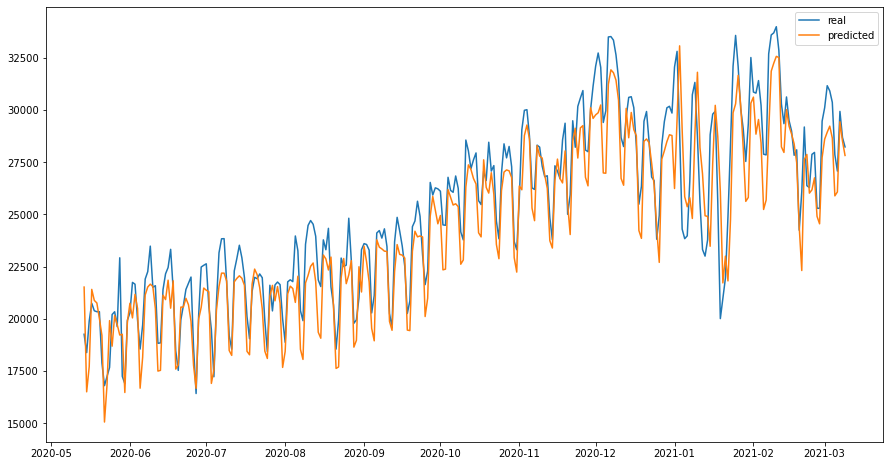

WITH FACTOR CORRECTOR


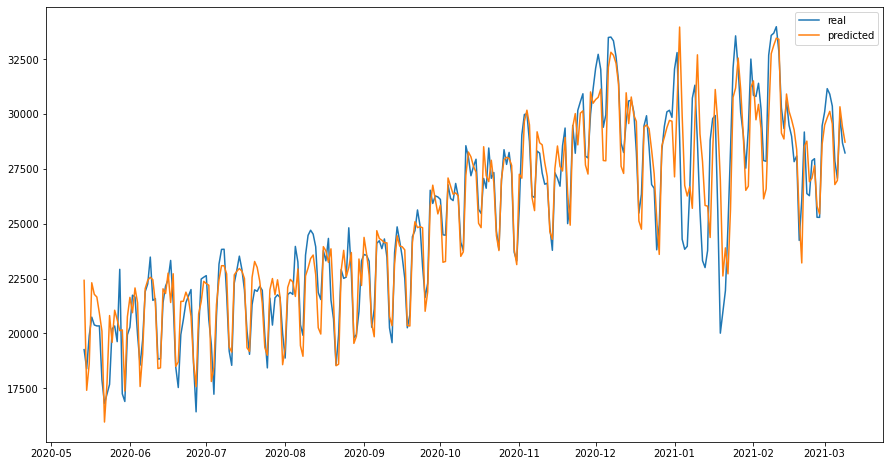

[27569.20611525]
Total number of observations:  1500
Train: (1200, 62)(1200, 1), 
Test: (300, 62)(300, 1)
Train RMSE: 0.23713330978404923
Test RMSE: 0.3949378219045868
Unnormalized RMSE: 1674.1668312301413
Unnormalized RMSE WITH CORRECTING FACTOR: 1394.6823584410713
best factor: 950


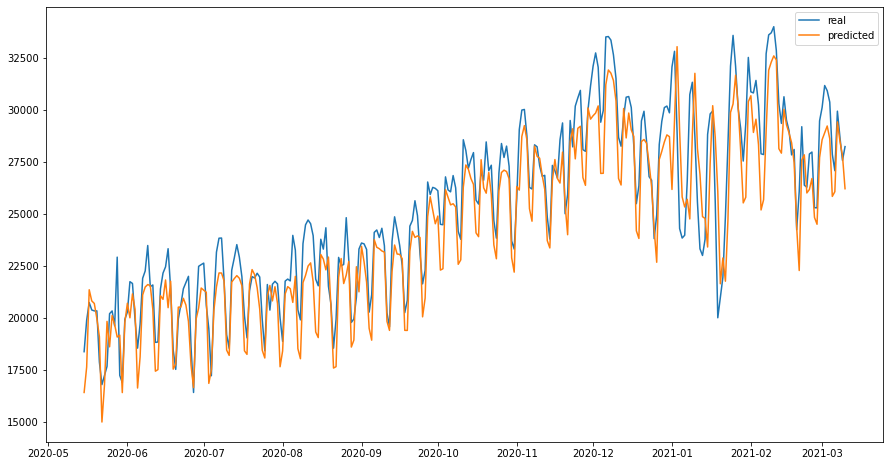

WITH FACTOR CORRECTOR


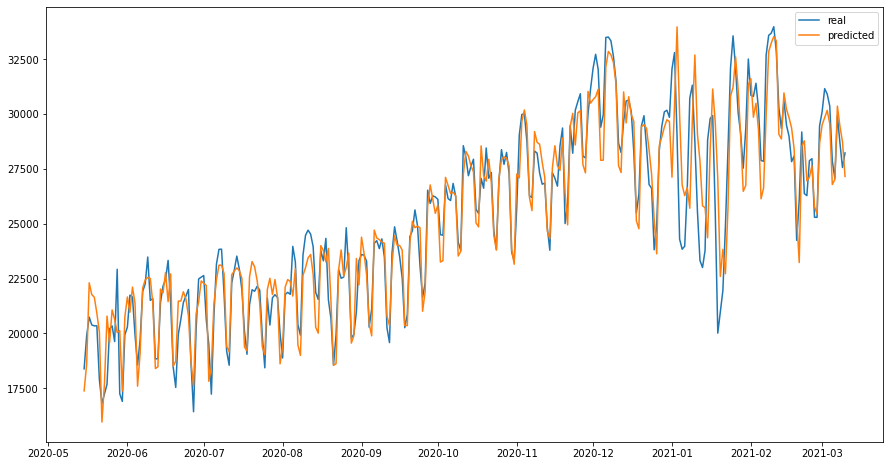

#####################################
HEY LOOK AT THOSE SEXY PREDICTIONS!!!
#####################################
forecast: [27564.01764165], standard deviation: 1394.4829892843281
forecast in logarithmic form: 10.224266492501767, standard deviation in logarithmic form: 0.04935257886372035


In [7]:
gimme_a_fucking_value(complete_df)